Copyright (c) 2023 Graphcore Ltd. All rights reserved.

# Sampling large graphs for IPUs using PyTorch Geometric


[![Run on Gradient](../../gradient-badge.svg)](https://console.paperspace.com/github/<runtime-repo>?machine=Free-IPU-POD4&container=<dockerhub-image>&file=<path-to-file-in-repo>)  [![Join our Slack Community](https://img.shields.io/badge/Slack-Join%20Graphcore's%20Community-blue?style=flat-square&logo=slack)](https://www.graphcore.ai/join-community)


In the previous tutorials we have been focusing on working with datasets comprising many small graphs. For some modern applications, however, we will need to operate on larger graphs characterised by increasing number of nodes (range 10M-10B) and edges (range 100M-100B): imagine having to build a recommendation system for a social network type of input graph, which can be constituted by a huge number of users (nodes) and relationships (edges). 

We might think of two routes to approach large graph problems:
- full batch training: this is the approach we have been using in [Tutorial 2](https://ipu.dev/O2u8MZ) when working with a single, relatively small graph. The aim is to generate embeddings for all the nodes at the same time: this means keeping the entire graph in memory, as well as all the node embeddings. If the size of the computational graph increases, the amount of memory required to hold graph and embeddings becomes challenging for modern accelerators. 
- mini-batching: alternatively, we can create mini-batches by sampling from the graph. When sampling from a larger graph we need to be extra careful to reduce the chances of the sampled nodes to be isolated from each other. Should that be the case, the mini-batches would no longer be representative of the whole graph which would negatively impact our machine learning task. The need here is to engineer effective sampling methods to make sure that the message passing scheme is still effective with large graphs. 

In this tutorial, we will demonstrate two sampling approaches widely used in literature to cope with increasing graph size. For each we will finish with training using the Graphcore IPU, which is a great fit for GNNs applications as explained in this [blog post](https://www.graphcore.ai/posts/accelerating-pyg-on-ipus-unleash-the-power-of-graph-neural-networks), and the PyTorch Geometric (PyG) integration for IPUs. You will learn how to: 
- effectively cluster nodes of your input graph; 
- sample neighbouring nodes of your input graph; 
- then, for both sampling methods, train your GNN on IPUs to classify papers from the PubMed dataset.

This notebook assumes some familiarity with PopTorch as well as PyTorch Geometric (PyG). For additional resources please consult:
- [PopTorch Documentation](https://docs.graphcore.ai/projects/poptorch-user-guide/en/latest/index.html),
- [PopTorch Examples and Tutorials](https://docs.graphcore.ai/en/latest/examples.html#pytorch),
- [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/),
- [PopTorch Geometric Documentation](https://docs.graphcore.ai/projects/poptorch-geometric-user-guide/en/latest/index.html).

[![Join our Slack
Community](https://img.shields.io/badge/Slack-Join%20Graphcore's%20Community-blue?style=flat-square&logo=slack)](https://www.graphcore.ai/join-community)

In [1]:
# Make imported python modules automatically reload when the files are changed
# needs to be before the first import.
%load_ext autoreload
%autoreload 2
# TODO: remove at the end of notebook development

## Environment setup

The best way to run this demo is on Paperspace Gradient's cloud IPUs because everything is already set up for you. To run the demo using other IPU hardware, you need to have the Poplar SDK enabled and the latest PopTorch Geometric wheel installed. Refer to the [getting started guide](https://docs.graphcore.ai/en/latest/getting-started.html#getting-started) for your system for details on how to enable the Poplar SDK and install the PopTorch wheels.

> You can install requirements directly from a notebook. You can:
>
> 1. Run commands by starting the line in a code cell with `!`, as shown in the first code block below. 
> 2. Install Python requirements with the `%pip` [magic command](https://ipython.readthedocs.io/en/stable/interactive/magics.html).
> 
> Use these methods to make it easier for your user to set up the environment they need.

In [2]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


To make it easier for you to run this tutorial, we read in some configuration related to the environment you are running the notebook in.

In [3]:
import os

dataset_directory = os.getenv("DATASETS_DIR", "data")

## Loading a large graph

We will use the `PubMed` dataset from the `Planetoid` node classification benchmarking suite to demonstrate both the clustering and the neighborhood sampling methods. Let's load it and print some statistics about it. 

In [37]:
import torch
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

transform = T.Compose([T.NormalizeFeatures(), T.AddSelfLoops()])

dataset = Planetoid(root=dataset_directory, name="PubMed", transform=transform)
data = dataset[0]  # Access the graph as Data object

print(f"Dataset: {dataset} ")
print(f"Number of graphs: {len(dataset)}: ")
print(f"Number of features: {dataset.num_features} ")
print(f"Number of classes: {dataset.num_classes} ")

print(data)

print(f"Total number of nodes: {data.num_nodes}")
print(f"Total number of edges: {data.num_edges}")

Dataset: PubMed() 
Number of graphs: 1: 
Number of features: 500 
Number of classes: 3 
Data(x=[19717, 500], edge_index=[2, 108365], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])
Total number of nodes: 19717
Total number of edges: 108365


As we can see above, the dataset consists of 19717 scientific publications from the PubMed database relative to diabetes classified into one of three classes. This is not a huge dataset, but it will serve our purpose to demonstrate the sampling approaches. 

## Clustering to train the large graph for node classification 

### Clustering the graph

The idea behind this method is that we can split the entire input graph into smaller sub-graph clusters. When loading the data into the model, we combine a number of clusters together, regrowing the edges removed in the clustering process. This graph of combined clusters is the mini-batch on which we can calculate layer-wise embeddings by performing message passing.
The clusters should also retain the connectivity of the original graph to avoid information loss: to achieve that we make sure that the small communities from the original graph are mirrored in the generated clusters, by minimising the amount of edge cuts when forming the clusters

A well known approach is [Cluster-GCN](https://arxiv.org/abs/1905.07953). The steps are:
- pre-processing: given a large graph, we partition it into groups of nodes and edges we name clusters. The clusters are formed by minimising the edge cuts required to achieve clusters of a particular number of nodes.
- mini-batch training: we load multiple clusters, re-instate the edges removed by the pre-processing clustering step, and load this reconstructed sub-graph in the device memory and apply message passing over it to compute the loss.

You can also check out our dedicated [Cluster-GCN example.](https://ipu.dev/PmAtSw)

Let's now proceed with the clustering. The first step is to use `torch_geometric.data.ClusterData` to partition our `Data` object into `num_clusters` clusters: under the hood it leverages the METIS algorithm to obtain the splits.

In [5]:
from torch_geometric.loader import ClusterData

num_clusters = 100

cluster_data = ClusterData(
    data, num_parts=num_clusters, recursive=False, save_dir=dataset_directory
)

print(f"The dataset has been split in {len(cluster_data)} clusters")

The dataset has been split in 100 clusters


We can now use the PyG `torch_geometric.loader.ClusterLoader` which merges clusters and their between-clusters links into mini-batches. 

In [6]:
from torch_geometric.loader import ClusterLoader

clusters_per_batch = 10

dynamic_size_dataloader = ClusterLoader(
    cluster_data,
    batch_size=clusters_per_batch,
)

dynamic_dataloader_iter = iter(dynamic_size_dataloader)
print(f"{next(dynamic_dataloader_iter) = }")
print(f"{next(dynamic_dataloader_iter) = }")

next(dynamic_dataloader_iter) = Data(x=[1948, 500], y=[1948], train_mask=[1948], val_mask=[1948], test_mask=[1948], edge_index=[2, 7104])
next(dynamic_dataloader_iter) = Data(x=[1968, 500], y=[1968], train_mask=[1968], val_mask=[1968], test_mask=[1968], edge_index=[2, 8366])


 The mini-batches have been created by combining clusters together, hence each mini-batch has a different size: you can observe how each mini-batch contains a different number of nodes and edges in the cell above. We will need to keep this in mind when preparing the mini-batches to feed into the IPU: the IPU relies on Ahead-Of-Time (AOT) compilation, hence it needs the input tensors to be fixed sizes.  Therefore we need to make sure that the mini-batches produced are fixed in size so they can be loaded correctly onto the IPU. 

Now we need an approach to make the mini-batches of clusters fixed size: we will use the `poptorch_geometric.FixedSizeClusterLoader` for this purpose. To use this loader we need to find the maximum number of nodes and edges in the mini-batches. The `FixedSizeClusterLoader` will then pad the mini-batches accordingly. To do so, we can use the helper method `FixedSizeOptions.from_loader` which handles this calculation by sampling the previously defined dynamic data loader, returning a `FixedSizeOption` object specifying the number of nodes and edges to pad the mini-batches to.

In [8]:
import poptorch
from poptorch_geometric import FixedSizeOptions, OverSizeStrategy

fixed_size_options = FixedSizeOptions.from_loader(
    dynamic_size_dataloader, sample_limit=10
)

print(fixed_size_options)

FixedSizeOptions(num_nodes=1996 (At least one node reserved for padding), num_edges=14891 (At least one edge reserved for padding), num_graphs=2 (At least one graph reserved for padding), node_pad_value=0.0, edge_pad_value=0.0, graph_pad_value=0.0, pad_graph_defaults={})


As we can see in the cell above, we now have a maximum number of nodes and edges that the `FixedSizeClusterLoader` loader from PopTorch Geometric will use to pad the mini-batches to. Let's see how:

In [12]:
from poptorch_geometric.cluster_loader import FixedSizeClusterLoader

train_dataloader = FixedSizeClusterLoader(
    cluster_data,
    batch_size=clusters_per_batch,
    fixed_size_options=fixed_size_options,
    over_size_strategy=OverSizeStrategy.TrimNodesAndEdges,
)

Let's now inspect a couple of mini-batches loaded by the dataloader:

In [13]:
train_dataloader_iter = iter(train_dataloader)
print(f"{next(train_dataloader_iter) = }")
print(f"{next(train_dataloader_iter) = }")

next(train_dataloader_iter) = DataBatch(x=[1996, 500], edge_index=[2, 14891], y=[1996], batch=[1996], edges_mask=[14891], graphs_mask=[2], nodes_mask=[1996], ptr=[3], test_mask=[1996], train_mask=[1996], val_mask=[1996], num_nodes=1996, num_edges=14891)
next(train_dataloader_iter) = DataBatch(x=[1996, 500], edge_index=[2, 14891], y=[1996], batch=[1996], edges_mask=[14891], graphs_mask=[2], nodes_mask=[1996], ptr=[3], test_mask=[1996], train_mask=[1996], val_mask=[1996], num_nodes=1996, num_edges=14891)


As expected, the loader has used the maximum number of nodes and edges contained in the `FixedSizeOptions` object and all the tensor shapes are consistent across mini-batches. Now that we have clustered and loaded the data compatibly with the AOT requirements of the IPU, the next step is to train a GNN model to classify the papers in our dataset.

### Training a GNN to classify papers in the PubMed dataset

The first step is to define a GNN model to carry out our classification task. We can easily re-use one of the models we defined in the previous tutorials, for example a simple GCN-based one, as using clustering does not impact model definition:

In [14]:
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super(GCN, self).__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(in_channels, 64, add_self_loops=False)
        self.conv2 = GCNConv(64, out_channels, add_self_loops=False)

    def forward(self, x, edge_index, train_mask=None, y=None):
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.log_softmax(x, dim=-1)

        if self.training:
            y = torch.where(train_mask, y, -100)
            loss = F.nll_loss(x, y)
            return x, loss
        return x

We can now create the PopTorch model and train it on the IPU:

In [15]:
model = GCN(dataset.num_features, dataset.num_classes)
model

GCN(
  (conv1): GCNConv(500, 64)
  (conv2): GCNConv(64, 3)
)

In [16]:
from torchinfo import summary

model.train()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005)
poptorch_model = poptorch.trainingModel(model, optimizer=optimizer)

summary(poptorch_model)

Layer (type:depth-idx)                   Param #
PoplarExecutor                           --
├─GCNConv: 1-1                           64
│    └─SumAggregation: 2-1               --
│    └─Linear: 2-2                       32,000
├─GCNConv: 1-2                           3
│    └─SumAggregation: 2-3               --
│    └─Linear: 2-4                       192
Total params: 32,259
Trainable params: 32,259
Non-trainable params: 0

The training loop looks like this:

In [17]:
from tqdm import tqdm

num_epochs = 5
train_losses = torch.empty(num_epochs, len(train_dataloader))

for epoch in range(num_epochs):
    bar = tqdm(train_dataloader)
    for i, data in enumerate(bar):
        _, mini_batch_loss = poptorch_model(
            data.x, data.edge_index, data.train_mask, data.y
        )
        train_losses[epoch, i] = float(mini_batch_loss.mean())
        bar.set_description(
            f"Epoch {epoch} training loss: {train_losses[epoch, i].item():0.6f}"
        )

  0%|          | 0/10 [00:00<?, ?it/s][17:05:59.925] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 8
[17:05:59.925] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 10
[17:05:59.943] [poptorch:cpp] [warning] %108 : float = prim::Constant() # /tmp/ipykernel_1115941/4056117028.py:14:0: torch.float64 constant cannot be represented as a torch.float32
[17:05:59.944] [poptorch:cpp] [warning] %234 : float = prim::Constant() # /tmp/ipykernel_1115941/4056117028.py:16:0: torch.float64 constant cannot be represented as a torch.float32
Epoch 4 training loss: 1.038110: 100%|██████████| 10/10 [00:00<00:00, 115.04it/s]


We can now detach the training model from the IPU:

In [18]:
poptorch_model.detachFromDevice()

Finally we can plot the mean of the loss to verify it decreases nicely:

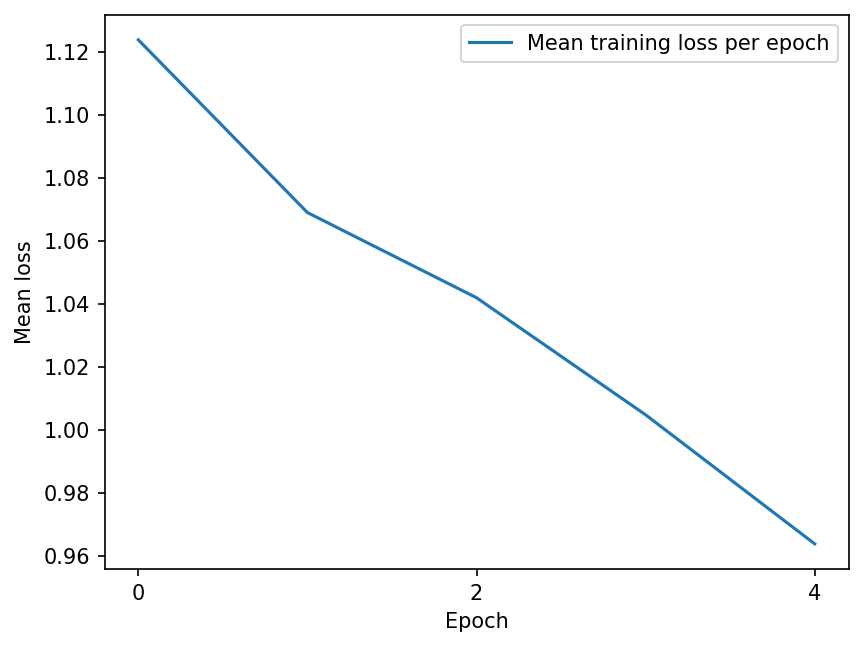

In [19]:
import matplotlib.pyplot as plt

plt.plot(train_losses.mean(dim=1))
plt.xlabel("Epoch")
plt.ylabel("Mean loss")
plt.legend(["Mean training loss per epoch"])
plt.xticks(torch.arange(0, num_epochs, 2))
plt.gcf().set_dpi(150)

## Neighbourhood sampling the computation graph for node classification

The neighbourhood sampling approach was firstly introduced in the [GraphSAGE](https://arxiv.org/abs/1706.02216v4) (SAmple and AGrEgate) paper for creating inductive node embeddings: the idea here is to learn how to aggregate node feature information from a node's K-hop neighbourhood, where K is the number of layers of our GNN and the number of iterations we want to perform. This means we need relatively small memory requirements: to generate the embeddings of a node we only need to know the K-hop neighbourhood structure around that node and the relative nodes' features, we don't need to store the rest of the graph. In this way, the mini-batches are going to be made of K-hop neighbourhoods which should fit nicely into the device's memory. 

### Neighbour sampling the graph

PyG provides the `torch_geometric.loader.NeighborLoader`, a data loader that performs neighbour sampling as per the GraphSAGE paper, allowing for mini-batching when full-batch update is not feasible. We can select how many neighboring nodes we'd like to be sampled for each node in each iteration, as well as the number of iterations (or number of hops) we'd like to go through. In this case, the `batch_size` argument represents how many nodes we want to sample from, which we can agree to refer to as 'target' nodes. Let's take a look at how to implement this in code: 

In [38]:
from torch_geometric.loader import NeighborLoader

num_neighbors = 10
num_iterations = 2
batch_size = 5

train_loader_sampling = NeighborLoader(
    data,
    shuffle=True,
    num_neighbors=[num_neighbors] * num_iterations,
    batch_size=batch_size,
)

train_sampling_iter = iter(train_loader_sampling)
print(f"{next(train_sampling_iter) = }")
print(f"{next(train_sampling_iter) = }")

sampled_data = next(train_sampling_iter)
print(
    f"Original graph node index of each target node in the mini-batch: {sampled_data.input_id}"
)
print(
    f"Original graph node index of each node in the mini-batch: {sampled_data.n_id}"
)  # shows the target nodes are the first 5

next(train_sampling_iter) = Data(x=[79, 500], edge_index=[2, 99], y=[79], train_mask=[79], val_mask=[79], test_mask=[79], n_id=[79], e_id=[99], input_id=[5], batch_size=5)
next(train_sampling_iter) = Data(x=[104, 500], edge_index=[2, 153], y=[104], train_mask=[104], val_mask=[104], test_mask=[104], n_id=[104], e_id=[153], input_id=[5], batch_size=5)
Original graph node index of each target node in the mini-batch: tensor([ 9165, 10092,  2161,  6147,  2501])
Original graph node index of each node in the mini-batch: tensor([ 9165, 10092,  2161,  6147,  2501, 14556, 10532,  2177,  2114,  8598,
         2365,  4151,  6045,  4546, 12435, 10244, 10993, 12535,  3654, 11554,
         7278,  1001, 19370,  6452,  3453,  9040,  8703,  6048,  3030, 14576,
        14327, 10386,  5418,  5460,  8611,  5287,  7526, 15304,    47, 13009,
         4822,  6125, 15081,  9353,  5268, 12978, 10675, 10265, 15066,  2128,
         4513, 15411,  6675, 15145, 10754, 15828, 10130, 10209,  3922,  7399,
         7177

In PyG, sampled nodes are sorted based on the order they were sampled. In fact, from inspecting the elements in the iterator, we can see how the first `batch_size` nodes (5 in this case) in the sampled sub-graph are the target ones, in other terms they represent the set of original mini-batch nodes. Those nodes are the ones we will want to use for training later on.

To comply with the AOT requirement in PopTorch on IPUs, we need to take action on those variable tensor sizes shown in the above cell and make them fixed size. To this purpose, we will leverage the `poptorch_geometric.FixedSizeNeighborLoader` in PopTorch Geometric: under the hood, this class takes the sub-graphs generated by the PyG `NeighborLoader` and then applies the PopTorch Geometric `FixedSizeCollater` to make the resulting shapes of the sub-graphs fixed size across sub-graphs.

Similarly to what we did in the clustering demonstration, we will first use the helper method `FixedSizeOptions.from_loader` which returns a `FixedSizeOption` object specifying the number of nodes and edges to pad the mini-batches to.

In [39]:
fixed_size_options = FixedSizeOptions.from_loader(
    train_loader_sampling, sample_limit=10
)

print(fixed_size_options)

FixedSizeOptions(num_nodes=167 (At least one node reserved for padding), num_edges=202 (At least one edge reserved for padding), num_graphs=2 (At least one graph reserved for padding), node_pad_value=0.0, edge_pad_value=0.0, graph_pad_value=0.0, pad_graph_defaults={})


We can pass the obtained maximum number of nodes and edges to the `poptorch_geometric.FixedSizeNeighborLoader`: 

In [40]:
from poptorch_geometric.neighbor_loader import FixedSizeNeighborLoader

train_loader_ipu = FixedSizeNeighborLoader(
    data,
    shuffle=True,
    num_neighbors=[num_neighbors] * num_iterations,
    fixed_size_options=fixed_size_options,
    over_size_strategy=OverSizeStrategy.TrimNodesAndEdges,
    batch_size=batch_size,
)

train_loader_ipu_iter = iter(train_loader_ipu)
print(f"{next(train_loader_ipu_iter) = }")
print(f"{next(train_loader_ipu_iter) = }")
print(f"{next(train_loader_ipu_iter).input_id = }")

next(train_loader_ipu_iter) = DataBatch(x=[167, 500], edge_index=[2, 202], y=[167], batch=[167], e_id=[214], input_id=[10], n_id=[167], ptr=[3], test_mask=[167], train_mask=[167], val_mask=[167], num_nodes=167, num_edges=202)
next(train_loader_ipu_iter) = DataBatch(x=[167, 500], edge_index=[2, 202], y=[167], batch=[167], e_id=[202], input_id=[5], n_id=[167], ptr=[2], test_mask=[167], train_mask=[167], val_mask=[167], num_nodes=167, num_edges=202)
next(train_loader_ipu_iter).input_id = tensor([ 1044, 12915,  6698,   863,  9400,     0,     0,     0,     0,     0])


As we can see, the resulting sub-graphs and tensor shapes have now fixed sizes using the number of nodes and edges previously determined! 

### Training using neighborhood sampling on IPUs

We will use a slight modification of the model we defined for the clustering approach demonstration and repeat the same steps to carry out our node classification task. We will leverage the `SAGEConv()` PyG layer to perform one iteration of the aggregate-and-update step. The selected aggregation scheme is the default one, a mean. The main aspect to be careful about is selecting which nodes we actually want to consider for training in each sub-graph. We need to make sure we train on those nodes we defined as the target ones and that we leave out of the loss calculation the padding sub-graph in each sub-graph. 

In [41]:
from torch_geometric.nn import SAGEConv


class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super(GraphSAGE, self).__init__()
        torch.manual_seed(1234)
        self.conv1 = SAGEConv(in_channels, 64, add_self_loops=False)
        self.conv2 = SAGEConv(64, out_channels, add_self_loops=False)

    def forward(self, x, edge_index, train_mask=None, y=None):
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.log_softmax(x, dim=-1)

        if self.training:
            loss = F.nll_loss(
                x[:batch_size], y[:batch_size]
            )  # Select only the target nodes for loss calculation, leave out the padding sub-graph in each sub-graph
            return x, loss
        return x

In [42]:
model_sampling = GraphSAGE(dataset.num_features, dataset.num_classes)
model_sampling

GraphSAGE(
  (conv1): SAGEConv(500, 64, aggr=mean)
  (conv2): SAGEConv(64, 3, aggr=mean)
)

In [43]:
from torchinfo import summary

model_sampling.train()
optimizer = poptorch.optim.Adam(model_sampling.parameters(), lr=0.001)
poptorch_model_sampling = poptorch.trainingModel(model_sampling, optimizer=optimizer)

summary(poptorch_model_sampling)

Layer (type:depth-idx)                   Param #
PoplarExecutor                           --
├─SAGEConv: 1-1                          --
│    └─MeanAggregation: 2-1              --
│    └─Linear: 2-2                       32,064
│    └─Linear: 2-3                       32,000
├─SAGEConv: 1-2                          --
│    └─MeanAggregation: 2-4              --
│    └─Linear: 2-5                       195
│    └─Linear: 2-6                       192
Total params: 64,451
Trainable params: 64,451
Non-trainable params: 0

In [44]:
from tqdm import tqdm
import numpy as np

num_epochs = 5
epoch_losses = torch.empty(num_epochs, len(train_loader_ipu))
print(len(train_loader_ipu))

for epoch in range(num_epochs):
    bar = tqdm(train_loader_ipu)
    for i, data in enumerate(bar):
        _, mini_batch_loss = poptorch_model_sampling(
            data.x, data.edge_index, data.train_mask, data.y
        )
        epoch_losses[epoch, i] = float(mini_batch_loss.mean())
        bar.set_description(
            f"Epoch {epoch} training loss: {epoch_losses[epoch, i].item():0.6f}"
        )

3943


  0%|          | 0/3943 [00:00<?, ?it/s][17:47:06.390] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 185
[17:47:06.391] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 187
Epoch 1 training loss: 0.635444:  79%|███████▉  | 3108/3943 [00:10<00:02, 301.28it/s]Exception ignored in: <function DataLoader.__del__ at 0x7f012c248940>
Traceback (most recent call last):
  File "/localdata/ariannas/repos/tests/venv_test/lib/python3.8/site-packages/poptorch/__init__.py", line 508, in __del__
    self.terminate()
  File "/localdata/ariannas/repos/tests/venv_test/lib/python3.8/site-packages/poptorch/__init__.py", line 504, in terminate
    if self._accessor is not None:
AttributeError: 'FixedSizeClusterLoader' object has no attribute '_accessor'
Epoch 4 training loss: 0.015951: 100%|██████████| 3943/3943 [00:14<00:00, 273.55it/s]


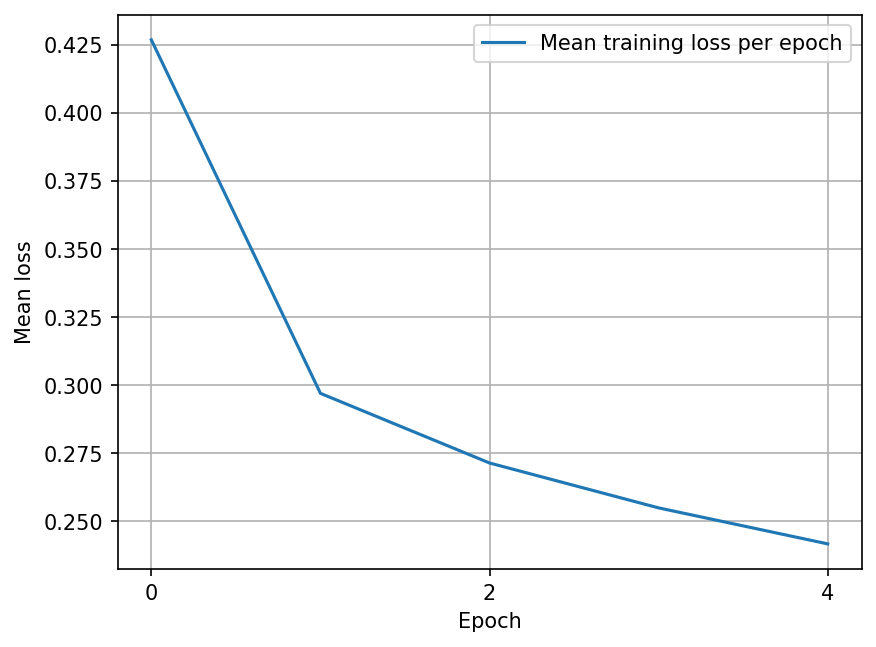

In [26]:
import matplotlib.pyplot as plt

plt.plot(epoch_losses.mean(dim=1))
plt.xlabel("Epoch")
plt.ylabel("Mean loss")
plt.legend(["Mean training loss per epoch"])
plt.grid(True)
plt.xticks(torch.arange(0, num_epochs, 2))
plt.gcf().set_dpi(150)

## Conclusion

In this tutorial we explored the main methods to deal with large graphs that otherwise wouldn't fit in memory, using two different sampling approaches and dedicated dataloaders to optimise performance on Graphcore IPUs. 

We demonstrated:
- how to effectively cluster nodes of your input graph, leveraging the `FixedSizeClusterLoader` to do so while respecting the AOT requirements on the IPU;
- how to sample neighbouring nodes of your input graph, using the `poptorch_geometric.FixedSizeNeighborLoader`;
- then, for both sampling methods above, how train your GNN on IPUs to classify papers from the PubMed dataset.

So far in this tutorial series we have worked with homogeneous graphs, however scaled up GNN problems are also very well suited to heterogeneous graphs: please check out our [heterogeneous graph tutorial](TODO add link) to know more about how to handle those on IPUs. More extensive node classification examples can be found in our  Gradient-Pytorch-Geometric/node-prediction repository. 

